In [35]:
!pip install torch

In [36]:
# Author: Edgar Terrazas Jaquez
# Date: 10-15-2024
# Initial trial of CSC Dataset exploration

import os

STORAGE_DIR = os.getcwd() + "\\storage"
USER_AGENT = "csc/torque"
MAX_CSC_ROWS = 600

In [37]:
# Unpack a zip file I uploaded to a DataRobot's notebook storage folder, unzip it, and print its first few contents

import zipfile
import shutil
import glob
import urllib
import urllib.error
import urllib.request


# From PyTorch Vision Utils:
def _urlretrieve(url, filename, chunk_size=1024 * 32) -> None:
    with urllib.request.urlopen(urllib.request.Request(url, headers={"User-Agent": USER_AGENT})) as response:
        with open(filename, "wb") as fh, tqdm(total=response.length) as pbar:
            while chunk := response.read(chunk_size):
                fh.write(chunk)
                pbar.update(len(chunk))

def download_from_url(
    url: str,
    download_dir: str,
    filename: str = None
):
    if not filename:
        filename = os.path.basename(url)
        
    os.makedirs(download_dir, exist_ok=True)
    
    file_path = os.fspath(os.path.join(download_dir, filename))

    if os.path.isfile(file_path):
        print(f"File already downloaded: {file_path}")
        return file_path

    print("This might take a while if file is too large or your internet connection is slow...")
    print(f"Downloading file: {url}")
    
    try:
        _urlretrieve(url, file_path)
    except (urllib.error.URLError, OSError) as e:
        print(f"There was an error while trying to download file from url: {url}")
        raise e

    # check integrity of downloaded file
    if not os.path.isfile(file_path):
        raise RuntimeError("File not found or corrupted.")

    print(f"Downloaded file successfully!")

    # Return downloaded file path for post-processing
    return file_path


def unpack_zip_file(dataset_zip, dr_storage_dir=STORAGE_DIR):
    print(f"Extracting zip: {dataset_zip}...")

    zip_file_name = os.path.basename(dataset_zip)
    csv_folder_name = zip_file_name.split('.')[0]
    extract_to_dir = os.path.join(dr_storage_dir, csv_folder_name)
    
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_to_dir)
        print(zip_ref.namelist()[:5])

    print(f"File was extracted to: {extract_to_dir}")
    
    # Return the folder where files were extracted 
    return extract_to_dir

def move_csv_files(current, destination) -> int:
    csv_files = glob.glob(current + '/*.csv')
    destination_folder = os.path.join(destination)

    csv_count = 0

    print("Moving CSV files...")
    
    os.makedirs(destination_folder, exist_ok=True)
    for file in csv_files:
        shutil.move(file, destination_folder)
        csv_count += 1

    print(f"Moved {csv_count} csv's to folder: {destination_folder}...")
    return csv_count


# This will contain the file url and STORAGE_DIR (for DataRobot)
def download_and_extract(url, download_dir):
    dataset_zip = download_from_url(url, download_dir)
    extracted_folder_path = unpack_zip_file(dataset_zip)
    return extracted_folder_path

In [38]:
# Function to pad a dataframe to have all tensors the same shape 
def pad_dataframe(df, max_rows=MAX_CSC_ROWS, padding_value=0):
    if len(df) < max_rows:
        # Padding is a dataframe of 0's
        padding = pd.DataFrame(padding_value, index=range(max_rows - len(df)), columns=df.columns)
        
        # Combine the padding df to the current df 
        return pd.concat([df, padding], ignore_index=True)
    
    return df

In [62]:
import pandas as pd
import os
import torch

from torch.utils.data import Dataset, DataLoader
from torch.utils.model_zoo import tqdm
from typing import Any, List, Tuple


# CSC = Comma Steering Control
# Defining a custom dataset here to use it in DataLoader later

# Generic CSC base class to specify 
# dataset name and download it automatically, unzip it, extract
# features (vehicle dynamics) and label (torque)
class CSCDataset(Dataset):
    base_url = "https://huggingface.co/datasets/commaai/commaSteeringControl/resolve/main/data/"
    storage_dir = os.getcwd() + '\\storage'
    
    def __init__(self, 
                 dataset: str, 
                 features: List, 
                 label: str = 'steerFiltered',
                 download: bool = False):
        """
        Defines a Comma Steering Control (CSC) dataset for a specific car model
        <https://huggingface.co/datasets/commaai/commaSteeringControl/tree/main/data>

        Args:
            dataset: dataset to download from hugging face (Ex: acura_rdx_2020.zip or acura_rdx_2020)
            feature_columns: CSC feature colums of your choosing
            label_column: CSC label column. steerFiltered by default (torque)
            download: Boolean to specify if it should download when instantiating this class
        """

        dataset_zip = self._preproc_dataset_name(dataset)

        # Folder name is the same as the zip file name without the .zip
        dataset_folder_name = dataset_zip.split('.')[0]

        # Dataset props
        self.dataset_zip = dataset_zip
        self.url = self.base_url + dataset_zip
        self.dataset_folder_path = os.path.join(self.storage_dir, dataset_folder_name)
        
        if download:
            self.download()

        # Training features props
        self.features = features
        self.label = label
        self.dataframes = []
        self.features_shape = len(features)
        self.label_shape = 1

        # 600 as a baseline, will be updated below
        # max_rows is the maximum number of rows a csv file has
        # This is to make sure the dataframe can be padded with 0's for
        # Torch's dataloader to work
        self.max_rows = 600

        for file in os.listdir(self.dataset_folder_path):
            csv_file_path = os.path.join(self.dataset_folder_path, file)
            df = pd.read_csv(csv_file_path)
            self.dataframes.append(df)
            
            if len(df) > self.max_rows:
                self.max_rows = len(df) 

    def __len__(self) -> int:
        _, num_csv = self.get_csv_metadata()
        return num_csv
    
    def __getitem__(self, idx) -> Any:
        # Select the dataframe (csv) to use
        df = self.dataframes[idx]

        padded_df = pad_dataframe(df, max_rows=self.max_rows)
        
        features = padded_df[self.features].values
        label = padded_df[self.label].values

        # Convert to torch tensors
        features = torch.tensor(features, dtype=torch.float64)
        label = torch.tensor(label, dtype=torch.float64)

        self.features_shape = features.shape
        self.label_shape = label.shape

        # TODO: Add logger instead
        print("Shape AFTER tensor")
        print(f"Features shape: {features.shape}, Label shape: {label.shape}")
        
        return features, label

    def download(self) -> None:
        if self._is_downloaded_extracted():
            print(f"Dataset is already downloaded and extracted and ready to use! Folder: {self.dataset_folder_path}")
            return

        download_and_extract(self.url, self.storage_dir)

        # Check if the folder is repeated (meaning there are 2 folders with same name)
        # Ex: FolderName/FolderName/example.csv
        dataset_folder_name = os.path.basename(self.dataset_folder_path)
        double_folder = os.path.join(self.dataset_folder_path, dataset_folder_name)
        
        if os.path.exists(double_folder):
            move_csv_files(double_folder, self.dataset_folder_path)
            os.removedirs(double_folder)

        zip = os.path.join(self.storage_dir, self.dataset_zip)
        os.remove(zip)
        
        self._check_integrity()

    def get_csv_metadata(self):
        """
        Gets metadata of the total number of csv's

        Returns (Tuple):
            total_size (in MB), number_of_csv_files
        """
        csv_files = glob.glob(f'{self.dataset_folder_path}/*.csv')
        total_size = 0
        csv_count = 0
        
        for file in csv_files:
            total_size += os.path.getsize(file)
            csv_count += 1

        size_mb = total_size / (1024 * 1024)
        
        return size_mb, csv_count

    def _check_integrity(self) -> None:
        # Might add more logic in this function (Ex: checking the download is not corrupted, etc..)
        if not self._is_downloaded_extracted():
            raise Exception(f"Dataset {self.dataset_zip} not downloaded/extracted...")
            
        print(f"Dataset downloaded and extracted, ready to use! Folder: {self.dataset_folder_path}")
    
    def _is_downloaded_extracted(self) -> bool:
        if not os.path.exists(self.dataset_folder_path):
            return False

        # Return True if folder is not empty 
        return not len(os.listdir(self.dataset_folder_path)) == 0

    def _preproc_dataset_name(self, dataset_name: str) -> str:
        """
        Preprocess dataset name to add .zip if it doesn't have it
        """

        add_zip = dataset_name + '.zip'
        return add_zip if '.zip' not in dataset_name else dataset_name

In [63]:
def collate_fn(data: List[Tuple[torch.Tensor, torch.Tensor]]):
    tensors, targets = zip(*data)
    features = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
    targets = torch.stack(targets)
    return features, targets


features = ['vEgo', 'steeringAngleDeg', 'aEgo', 'latAccelSteeringAngle']
label = 'steerFiltered'

# Create DataLoader
dataset = CSCDataset('AUDI_Q3_2ND_GEN', features, label=label, download=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

Dataset is already downloaded and extracted and ready to use! Folder: c:\Users\ragde\OneDrive\Desktop\Oakland University\Grad\Semester 2 (Fall 2024)\Artificial Intelligence\Project\code\CSI_5130_Torque_Prediction_NN\src\notebooks\storage\AUDI_Q3_2ND_GEN


In [64]:
for inputs, targets in dataloader:
    print("Inputs")
    print(inputs)

    print("Targets")
    print(targets)
    
    print(f"[inputs] dtype: {inputs.dtype}, shape: {inputs.shape}")
    print(f"[targets] dtype: {targets.dtype}, shape: {targets.shape}")
    break

total_dataset_size, _ = dataset.get_csv_metadata()
total_dataset_size = round(total_dataset_size, 3)
print(f"Total file size of dataset: {total_dataset_size} MB")

Shape AFTER tensor
Features shape: torch.Size([601, 4]), Label shape: torch.Size([601])
Inputs
tensor([[[ 2.9713e+01,  0.0000e+00,  4.9186e-02, -1.6394e-01],
         [ 2.9721e+01, -1.0280e-01,  7.0013e-02, -1.4018e-01],
         [ 2.9727e+01, -3.9780e-01,  7.7726e-02, -7.1593e-02],
         ...,
         [ 3.1330e+01, -2.6990e+00, -1.1717e-01,  3.9666e-01],
         [ 3.1339e+01, -2.6000e+00,  1.3116e-02,  3.7777e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]]],
       dtype=torch.float64)
Targets
tensor([[-1.2653e-01, -1.9383e-01, -2.5937e-01, -1.8686e-01, -2.1651e-01,
         -2.0331e-01, -1.9011e-01, -2.5676e-01, -3.1274e-01, -2.2329e-01,
         -1.9031e-01, -2.5647e-01, -3.2279e-01, -2.8653e-01, -2.6669e-01,
         -2.7620e-01, -2.1014e-01, -2.4652e-01, -2.1694e-01, -2.7684e-01,
         -3.3644e-01, -1.8653e-01, -1.5002e-01, -1.6330e-01, -1.5360e-01,
         -2.1972e-01, -1.2676e-01, -1.1707e-01, -1.8348e-01, -2.2670e-01,
         -2.3292e-01, -1.6069e-

In [56]:
from tabulate import tabulate

def show_tensors_in_table(dataloader, batch_index):
  for i, (inputs, targets) in enumerate(dataloader):
    
    if not i == batch_index:
      continue

    input_data = inputs[0].numpy()
    target_data = targets[0].numpy()
    print(input_data.shape)
    print(target_data.shape)

    # Prepare data for tabulate
    table_data = []
    for j, feature in enumerate(dataloader.dataset.features):
      table_data.append([feature] + list(input_data[:, j]))

    table_data.append([dataloader.dataset.label] + list(target_data))

    # Print table
    print(tabulate(table_data, headers=["Name"] + [f"Row {i}" for i in range(input_data.shape[0])], tablefmt="grid"))
    break

show_tensors_in_table(dataloader, 0)

Shape BEFORE tensor
Features shape: (601, 4), Label shape: (601,)
Shape AFTER tensor
Features shape: torch.Size([601, 4]), Label shape: torch.Size([601])
(601, 4)
(601,)
+-----------------------+------------+------------+------------+-------------+------------+------------+------------+------------+------------+-----------+------------+------------+------------+------------+-----------+------------+------------+------------+------------+--------------+------------+------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+------------+------------+------------+-------------+------------+------------+------------+------------+-------------+------------+-------------+------------+------------+------------+--------------+------------+------------+------------+------------+------------+----

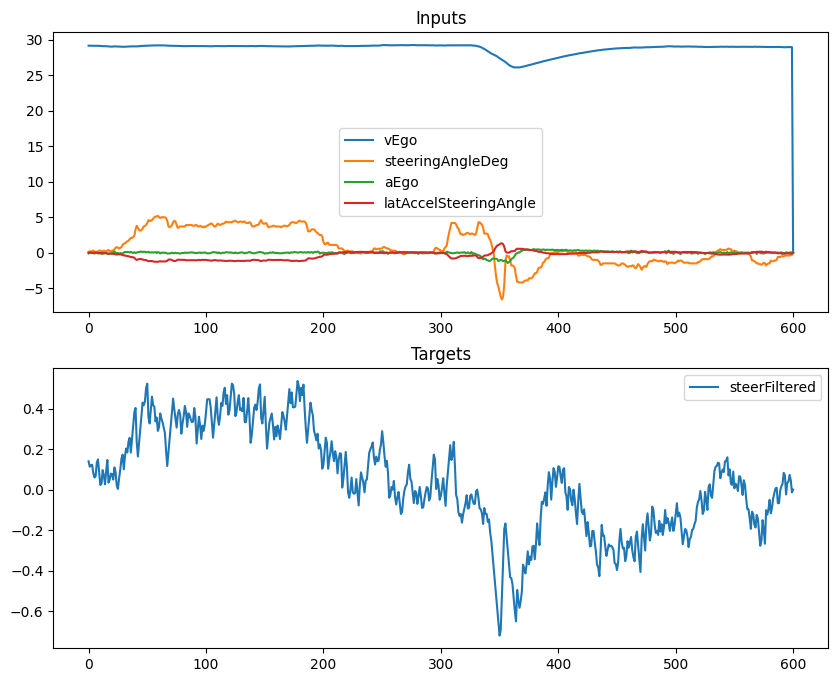

In [7]:
import matplotlib.pyplot as plt

def visualize_tensors(dataloader, batch_index):
  for i, (inputs, targets) in enumerate(dataloader):
    if i == batch_index:
      fig, axs = plt.subplots(2, 1, figsize=(10, 8))
      
      # Plot inputs
      for j, feature in enumerate(dataloader.dataset.features):
        axs[0].plot(inputs[0, :, j].numpy(), label=feature)
      axs[0].set_title('Inputs')
      axs[0].legend()
      
      # Plot targets
      axs[1].plot(targets[0].numpy(), label=dataloader.dataset.label)
      axs[1].set_title('Targets')
      axs[1].legend()
      
      plt.show()
      break

visualize_tensors(dataloader, 0)

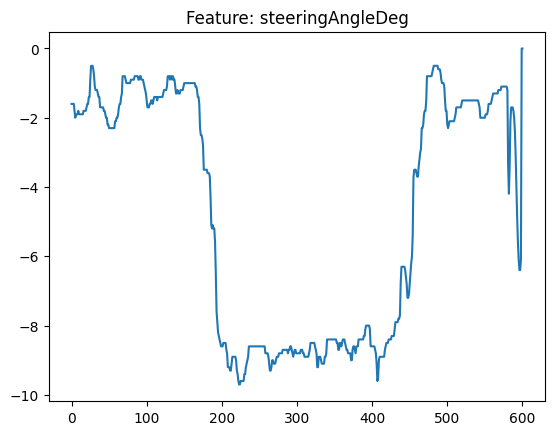

In [ ]:
# Visualize a batch of data of my selection with the feature of my selection

def visualize_batch_data(dataloader, batch_index, feature):
    for i, (inputs, targets) in enumerate(dataloader):
        if i == batch_index:
            feature_index = dataloader.dataset.features.index(feature)
            feature_data = inputs[0, :, feature_index].numpy()
            plt.plot(feature_data)
            plt.title(f'Feature: {feature}')
            plt.show()
            break

visualize_batch_data(dataloader, 6, 'steeringAngleDeg')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict, defaultdict

class TorquePredictor(nn.Module):
    def __init__(self, 
                 input_features, 
                 hidden_layers_arch=[64, 32], 
                 output_features=1) -> None:
        super(TorquePredictor, self).__init__()

        self.ARCH = [*hidden_layers_arch]

        # Initialize hidden layers
        layers = []

        # Counts keeps a track of how many of a certain layer we have
        counts = defaultdict(int)
        
        def add(name: str, layer: nn.Module) -> None:
            # Convertng hidden layers into an Ordered Dict down below
            layers.append((f"{name}{counts[name]}", layer))
            counts[name] += 1

        layer_in = input_features
        
        for x in self.ARCH:
            # linear-relu
            add("Linear", nn.Linear(layer_in, x))
            add("ReLU", nn.ReLU(True))
            layer_in = x

        # Add output torque predictor with sigmoid layer since 
        # torque is normalized (in the commaSteeringControl dataset)
        out_layers = [
          ('LinearOut', nn.Linear(hidden_layers_arch[-1], output_features)),
          ('Sigmoid', nn.Sigmoid())
        ]
        
        self.backbone = nn.Sequential(OrderedDict(layers))
        self.output_predictor = nn.Sequential(OrderedDict(out_layers))

        
    def forward(self, x: torch.Tensor):
        x = self.backbone(x)
        x = self.classifier(x)
        
        return x

In [ ]:
# Split into training and test dataset, setup the training loop with 5 epochs, evaluation with accuracy, initialize Torque Predictor model with the features, run training loop and give accuracy.

from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset

# Split into training and test dataset
train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Initialize model
_, num_features = dataset.get_csv_metadata()
model = TorquePredictor(num_features)

# Setup training
optimizer = Adam(model.parameters())
loss_fn = nn.MSELoss()

# Training loop
for epoch in range(5):
    model.train()
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            outputs = model(inputs)
            predicted = torch.round(outputs.data)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch: {epoch+1}, Accuracy: {accuracy}%')

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = SGD(
  model.parameters(),
  lr=0.4,
  momentum=0.9,
  weight_decay=5e-4,
)

In [ ]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer
    optimizer.step()

In [ ]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

In [ ]:
num_epochs = 20

# TODO: Split data into training and test sets

for epoch_num in tqdm(range(1, num_epochs + 1)):
  train(model, dataloader["train"], criterion, optimizer, scheduler)
  metric = evaluate(model, dataflow["test"])
  print(f"epoch {epoch_num}:", metric)